# Ontario Electricity Demand Forecast -- Timeseries Analysis

## **Approach**

* Read the data.
* Preprocess the data.
* Perform Exploratory Data Analysis (EDA).
* Check for stationarity in the data.
* Analyze ACF and PACF plots.
* Build the following models:
    * XGBoost
    * Random Forest
    * SVR 
* Utilising Gridsearch for Best Parameters and Model
* Evaluate the models' performance.

## Attributes
* Date
* Weekday
* Temperature
* Hourly Ontario Electricity Price (HOEP)
* Wind Speed
* Relative Humidity
* Humidex
* Dew Point
* Pressure at the Station
* Ontario_Demand

# Import Libraries

In [220]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [448]:
#importing all required libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
import scipy.stats
import pylab
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.stats import kurtosis
from scipy import stats, special
from scipy.stats import skew

# Read Dataset

In [222]:
#loading dataset
data = pd.read_csv('Sample Dataset.csv')
df = data.copy()

# Exploratory Data Analysis (EDA)

In [456]:
#checking first five rows of the data
df.head(3)

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
datetime,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,Friday,0,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67
2016-01-01 01:00:00,2016-01-01,Friday,1,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63
2016-01-01 02:00:00,2016-01-01,Friday,2,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59


In [224]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,39408.0,11.625076,6.945136,0.00,6.00,12.00,18.00,23.00
HOEP,39408.0,13.923340,11.902378,-2.77,3.30,12.95,22.51,44.11
Ontario_Demand,39408.0,15397.914205,2201.241563,9831.00,13775.00,15272.00,16881.00,24281.00
Temperature,39408.0,9.421272,10.899602,-26.00,0.80,8.60,19.00,35.10
Windchill_Index,39408.0,6.565978,13.513148,-39.66,-3.95,5.67,18.58,37.94
Wind_Speed,39408.0,16.854243,9.220125,0.00,10.00,16.00,22.00,80.00
Humidex,39408.0,9.859521,14.325742,-31.10,-1.68,7.86,22.35,50.35
Relative_Humidity,39408.0,68.028598,16.773789,13.00,57.00,69.00,81.00,100.00
Dew_Point,39408.0,3.330397,10.269080,-31.60,-4.40,3.00,12.10,25.10
Pressure_Station,39408.0,99.533605,0.776696,96.49,99.05,99.54,100.04,102.41


In [225]:
df.shape

(39408, 12)

In [226]:
data.nunique()

Date                 1827
Weekday                 7
Hour                   24
HOEP                 4566
Ontario_Demand       9374
Temperature           578
Windchill_Index      5341
Wind_Speed             68
Humidex              5860
Relative_Humidity      88
Dew_Point             531
Pressure_Station      547
dtype: int64

In [458]:
# checking the structure of data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39408 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39408 non-null  object 
 1   Weekday            39408 non-null  object 
 2   Hour               39408 non-null  int64  
 3   HOEP               39408 non-null  float64
 4   Ontario_Demand     39408 non-null  int64  
 5   Temperature        39408 non-null  float64
 6   Windchill_Index    39408 non-null  float64
 7   Wind_Speed         39408 non-null  int64  
 8   Humidex            39408 non-null  float64
 9   Relative_Humidity  39408 non-null  int64  
 10  Dew_Point          39408 non-null  float64
 11  Pressure_Station   39408 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 3.9+ MB


In [228]:
#checking missing values
df.isnull().sum()

Date                 0
Weekday              0
Hour                 0
HOEP                 0
Ontario_Demand       0
Temperature          0
Windchill_Index      0
Wind_Speed           0
Humidex              0
Relative_Humidity    0
Dew_Point            0
Pressure_Station     0
dtype: int64

In [229]:
df.Date

0        2016-01-01
1        2016-01-01
2        2016-01-01
3        2016-01-01
4        2016-01-01
            ...    
39403    2020-12-31
39404    2020-12-31
39405    2020-12-31
39406    2020-12-31
39407    2020-12-31
Name: Date, Length: 39408, dtype: object

In [230]:
# Merging Date and Hour into a Single Column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Hour'].astype(str) + ':00:00')

In [231]:
# Set the new datetime column as the index
df.set_index('datetime', inplace=True)

In [232]:
# max data in the dataset
df.index.max()

Timestamp('2020-12-31 23:00:00')

In [233]:
# min date
df.index.min()

Timestamp('2016-01-01 00:00:00')

In [234]:
# Total date points in the dataset
df.index.max()-df.index.min()

Timedelta('1826 days 23:00:00')

In [235]:
# checking the structure of data after converting datetime format
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39408 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39408 non-null  object 
 1   Weekday            39408 non-null  object 
 2   Hour               39408 non-null  int64  
 3   HOEP               39408 non-null  float64
 4   Ontario_Demand     39408 non-null  int64  
 5   Temperature        39408 non-null  float64
 6   Windchill_Index    39408 non-null  float64
 7   Wind_Speed         39408 non-null  int64  
 8   Humidex            39408 non-null  float64
 9   Relative_Humidity  39408 non-null  int64  
 10  Dew_Point          39408 non-null  float64
 11  Pressure_Station   39408 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 3.9+ MB


## Univariate Analysis

In [443]:
def plot_hist_boxplot(column):
    fig,[ax1,ax2]=plt.subplots(1,2,figsize=(12,5))
    sns.distplot(df[df[column].notnull()][column],ax=ax1)
    sns.boxplot(y=df[df[column].notnull()][column],ax=ax2)
    print("skewness : ",skew(df[df[column].notnull()][column]))
    print("kurtosis : ",kurtosis(df[df[column].notnull()][column]))
    plt.show()

skewness :  -0.033816684489666175
kurtosis :  -1.188492092532319


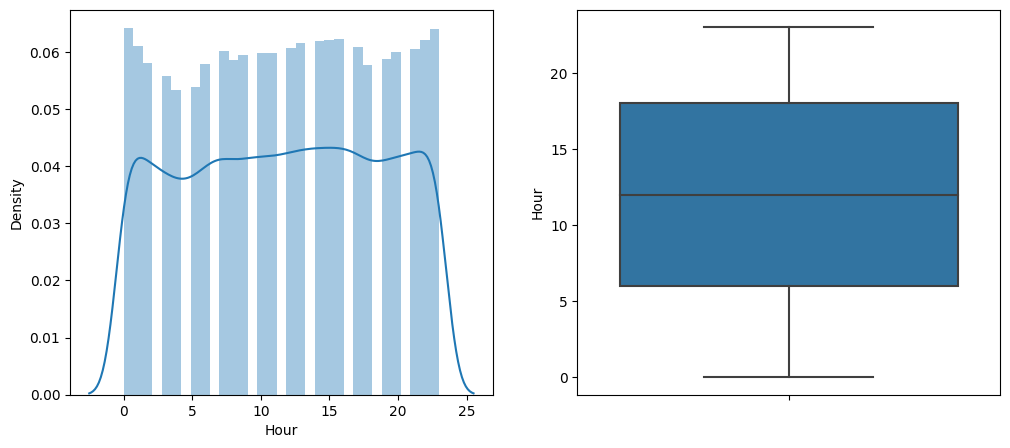

skewness :  0.5470867170558923
kurtosis :  -0.7138721407463073


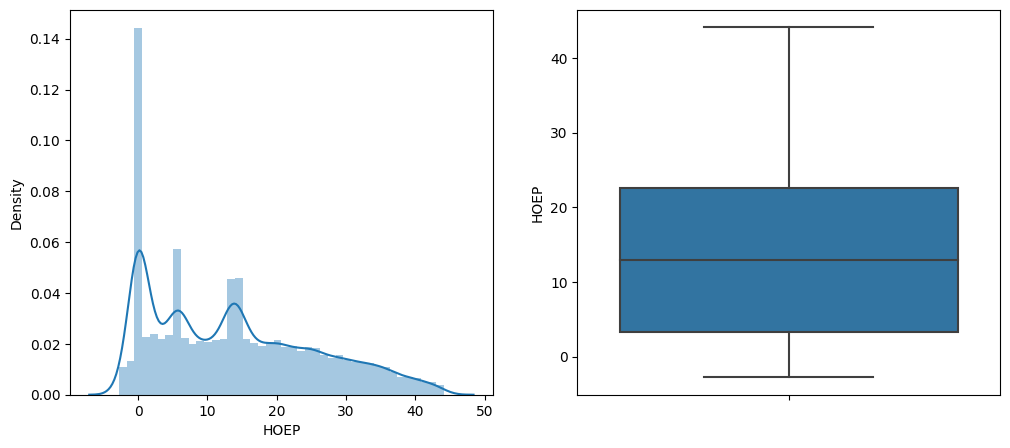

skewness :  0.3249866128303272
kurtosis :  -0.22575143509050788


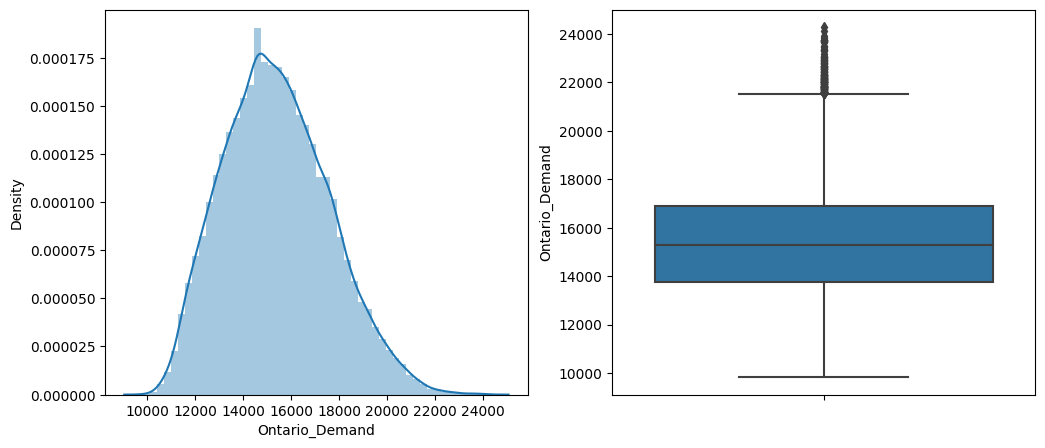

skewness :  -0.019990757986231504
kurtosis :  -0.8963431029429918


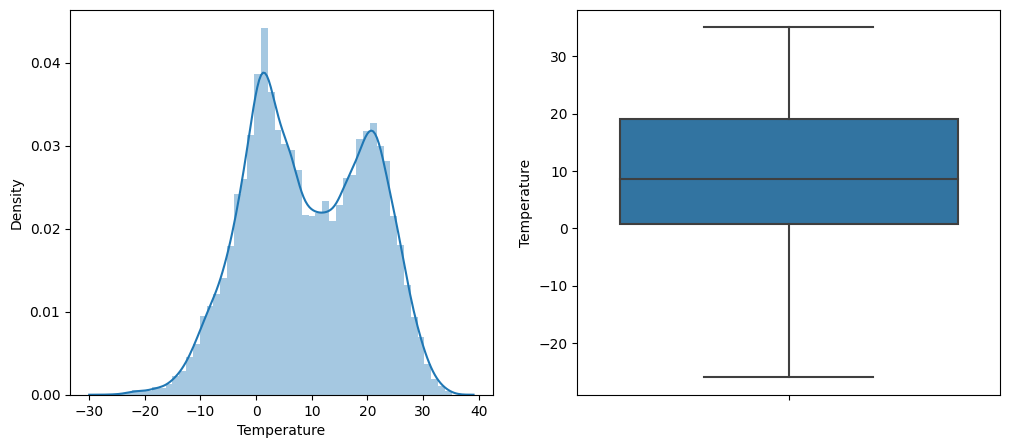

skewness :  -0.06949345199223068
kurtosis :  -0.8741598769957792


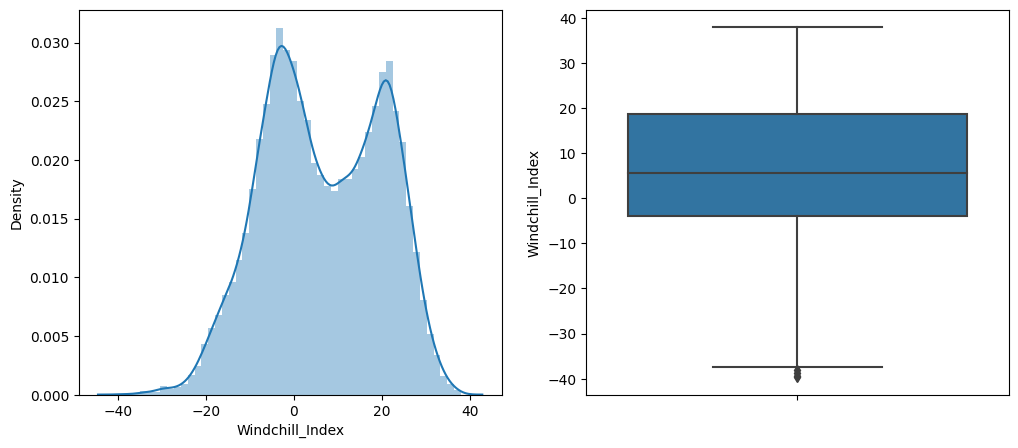

skewness :  0.8882823978576977
kurtosis :  0.9586817694593073


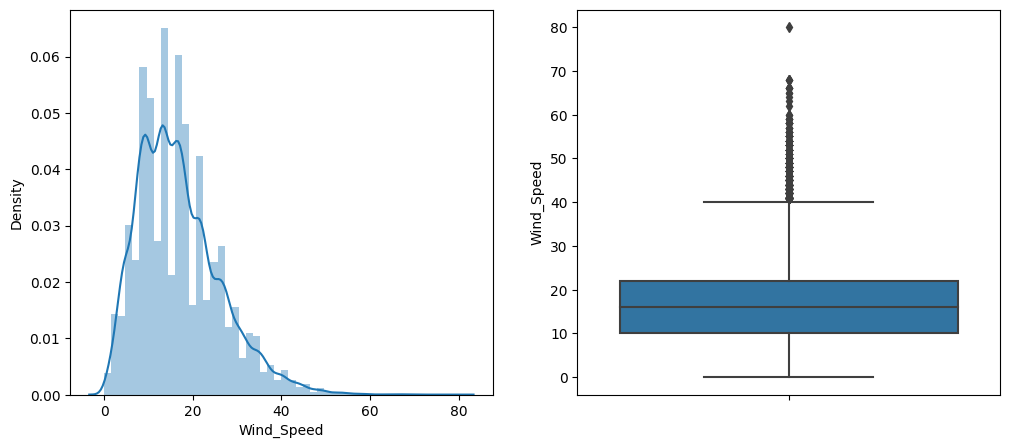

skewness :  0.12871782784106195
kurtosis :  -0.995138607950143


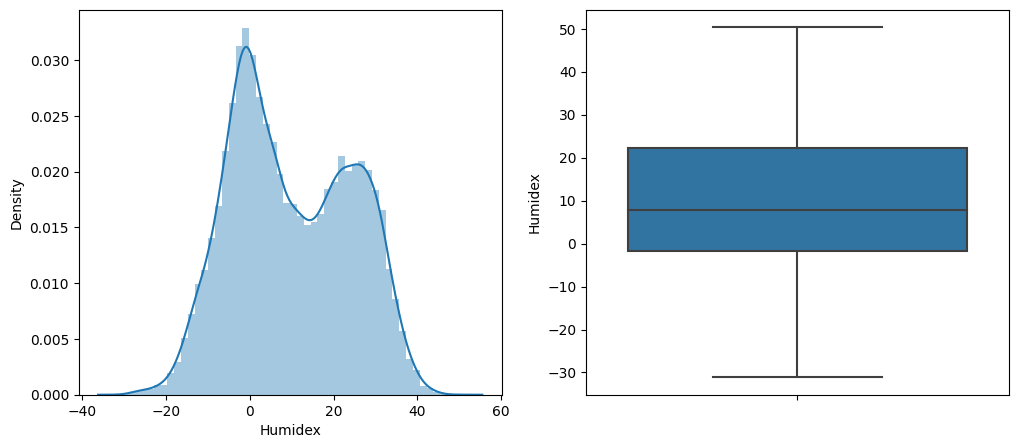

skewness :  -0.30560712955673075
kurtosis :  -0.5272711877762091


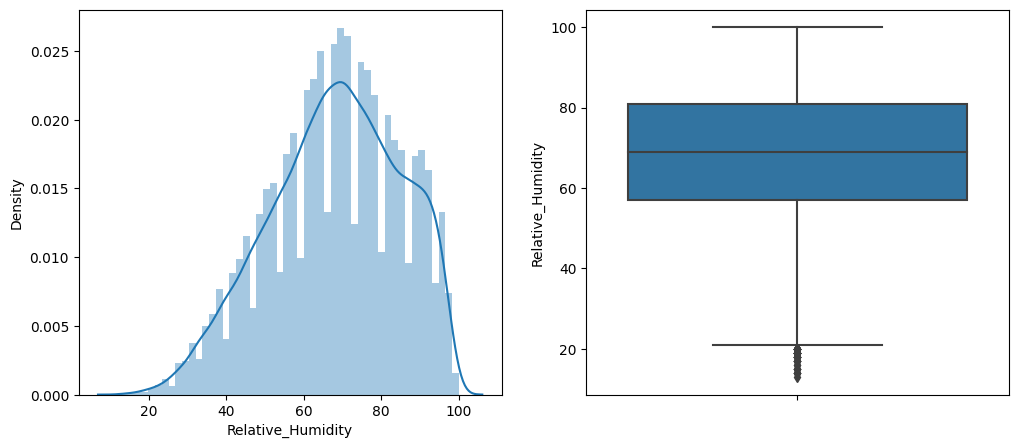

skewness :  -0.16110305834451302
kurtosis :  -0.7782857468243471


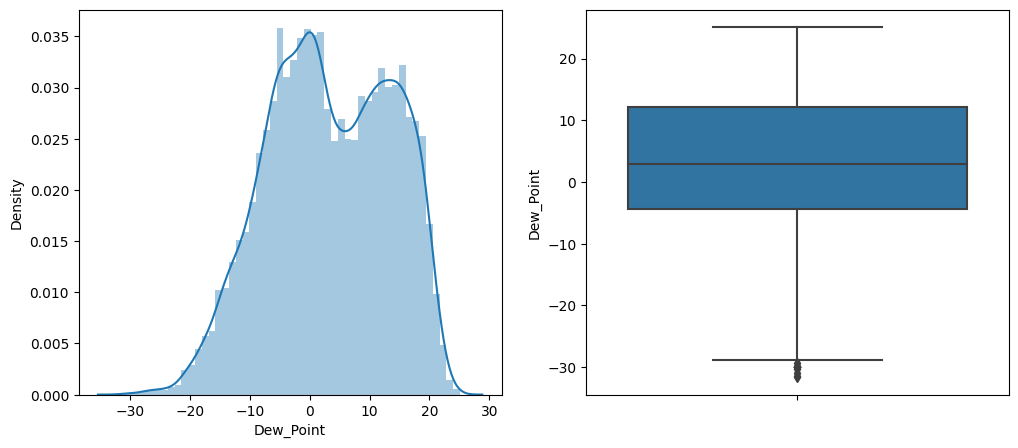

skewness :  -0.06904906337776281
kurtosis :  0.3244053174452546


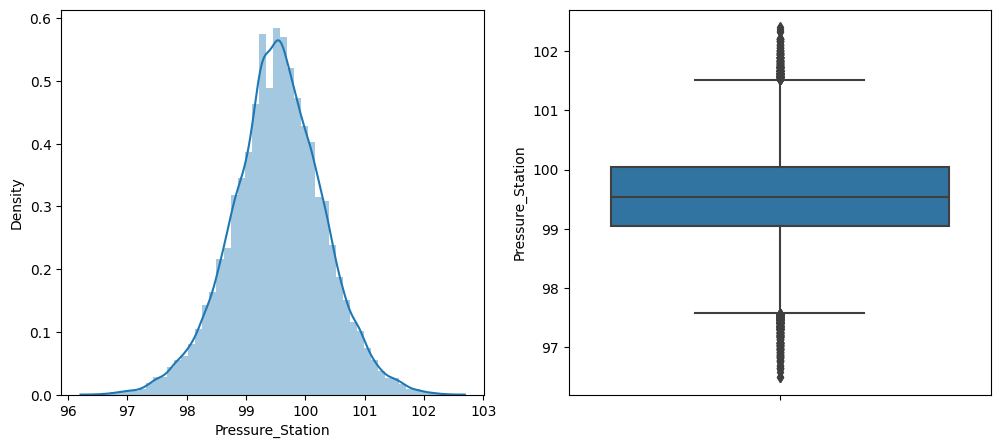

In [449]:
for col in df.columns:
    if col != 'Date' and col != 'Weekday':
        plot_hist_boxplot(col)

In [451]:
# Outliers 
Q1 = df['Windchill_Index'].quantile(0.25)
Q3 = df['Windchill_Index'].quantile(0.75)
IQR = Q3 - Q1
df[(df['Windchill_Index'] < (Q1 - 1.5 * IQR)) | (df['Windchill_Index'] > (Q3 + 1.5 * IQR))]

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station
datetime,,,,,,,,,,,,
2016-02-13 05:00:00,2016-02-13,Saturday,5,0.00,15929,-23.5,-37.99,34,-27.19,62,-28.9,100.19
2016-02-13 06:00:00,2016-02-13,Saturday,6,0.00,16344,-25.0,-39.66,33,-28.86,59,-30.9,100.34
2016-02-13 07:00:00,2016-02-13,Saturday,7,2.11,17035,-25.8,-38.83,24,-30.19,59,-31.6,100.46
2016-02-13 08:00:00,2016-02-13,Saturday,8,38.65,17749,-26.0,-39.47,24,-31.10,61,-31.5,100.57


#### **Observations**

* Since, the outliers are few and such peaks can occur in physical parameters, which are uncontrollable, they can be ignored. 
* Also, if the correlation of these Features with Target feature are insignificant, then it wouldn't have an impact on the target variable.

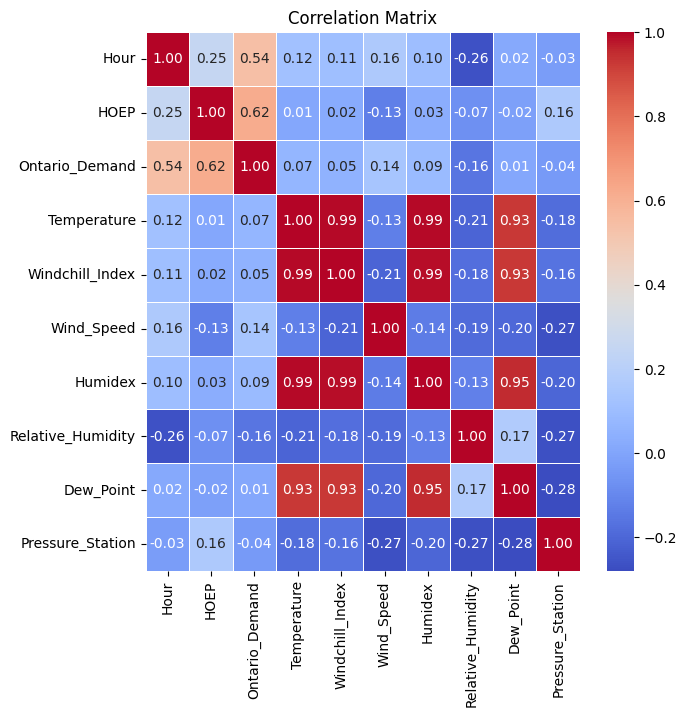

In [237]:
# correlation with other features:
corr_matrix = df.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### **Observations**
* HOEP Column in highly correlated with Ontario_Demand
* Reviewing the other features correlated with eachother to remove Multicollinearity

In [280]:
correlations = df.corr().unstack().sort_values(ascending=False) 
correlations['HOEP']

HOEP                 1.000000
Ontario_Demand       0.615273
Hour                 0.251456
Pressure_Station     0.164161
Humidex              0.030895
Windchill_Index      0.020256
Temperature          0.009442
Dew_Point           -0.015680
Relative_Humidity   -0.070164
Wind_Speed          -0.128610
dtype: float64

In [239]:
# select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

In [240]:
numeric_df.columns

Index(['Hour', 'HOEP', 'Ontario_Demand', 'Temperature', 'Windchill_Index',
       'Wind_Speed', 'Humidex', 'Relative_Humidity', 'Dew_Point',
       'Pressure_Station'],
      dtype='object')

In [241]:
# Coverting the numeric columns
for column in numeric_df.columns:
    numeric_df[column] = pd.to_numeric(df[column], errors='coerce')

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39408 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               39408 non-null  object 
 1   Weekday            39408 non-null  object 
 2   Hour               39408 non-null  int64  
 3   HOEP               39408 non-null  float64
 4   Ontario_Demand     39408 non-null  int64  
 5   Temperature        39408 non-null  float64
 6   Windchill_Index    39408 non-null  float64
 7   Wind_Speed         39408 non-null  int64  
 8   Humidex            39408 non-null  float64
 9   Relative_Humidity  39408 non-null  int64  
 10  Dew_Point          39408 non-null  float64
 11  Pressure_Station   39408 non-null  float64
dtypes: float64(6), int64(4), object(2)
memory usage: 3.9+ MB


In [459]:
# Time Series Visualisation Function

def plot_timeseries(numeric_df, x):

#data visualization
    d2 = numeric_df.copy()

# Drop columns that should not be resampled in this context
    d2 = d2.drop(columns=['Hour', 'HOEP'])  # Adjust the columns as necessary

    for i in d2:
    ## normalising data using min max scaling so it can be compared
        mini = min(d2[i])
        maxi = max(d2[i])
        d2[i] = (d2[i]- mini)/(maxi-mini)
    
        plt.figure(figsize=(10,3))
        d2[i].resample(x).mean().plot(legend=i) #resamples data in daily intervals
        (d2['Ontario_Demand']*0.7).resample(x).mean().plot(style='--', legend='Ontario_Demand')
        if x == 'D':
            plt.title(f'Daily Resampled and Normalized Data for {i}')
        elif x == 'M':
            plt.title(f'Monthly Resampled and Normalized Data for {i}')
        elif x == 'H':
            plt.title(f'Hourly Resampled and Normalized Data for {i}')
        else:
            plt.title(f'Yearly Resampled and Normalized Data for {i}')
        plt.legend()
        plt.show()

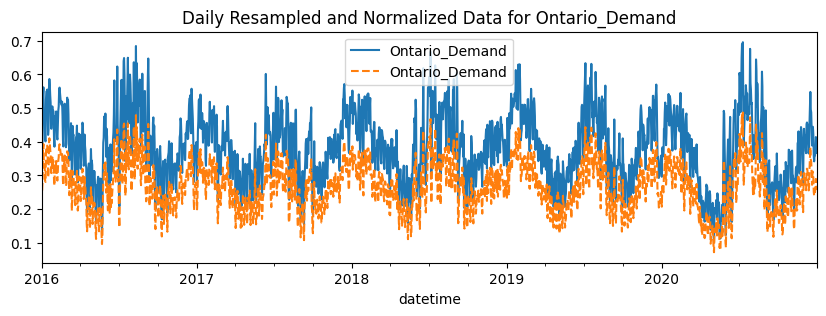

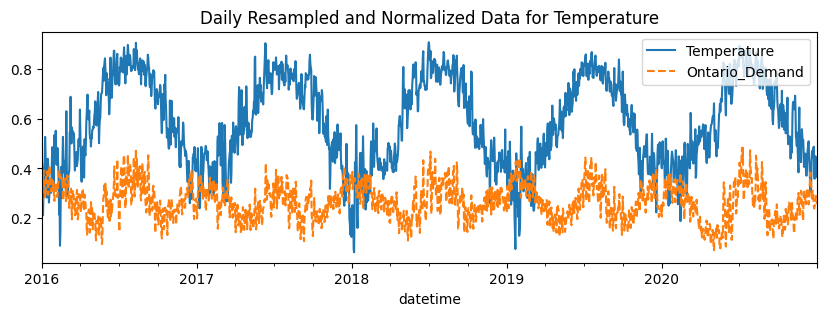

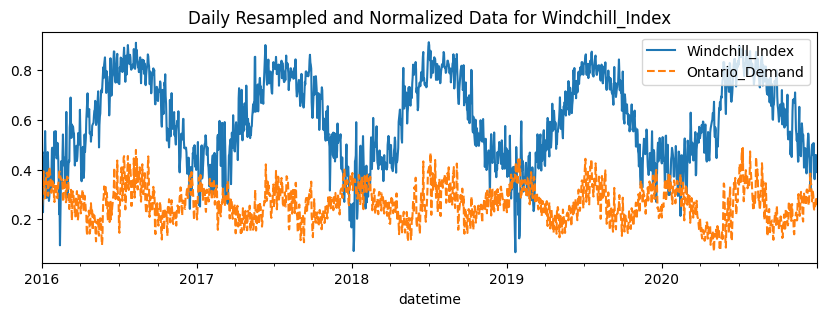

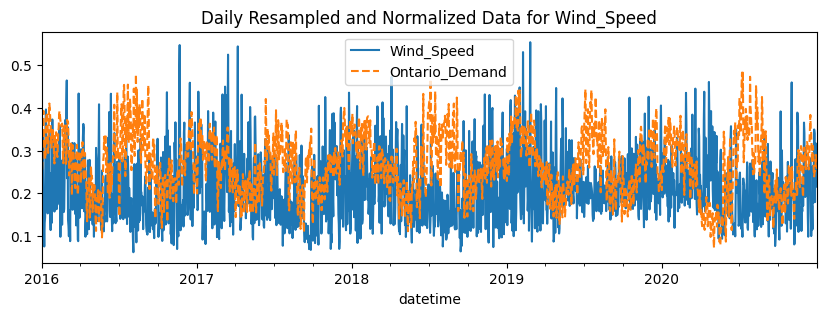

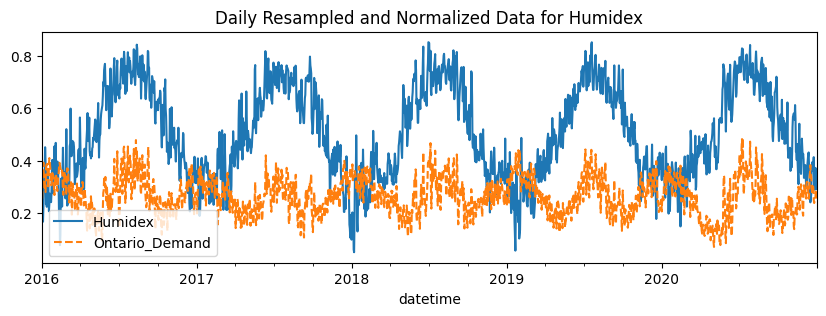

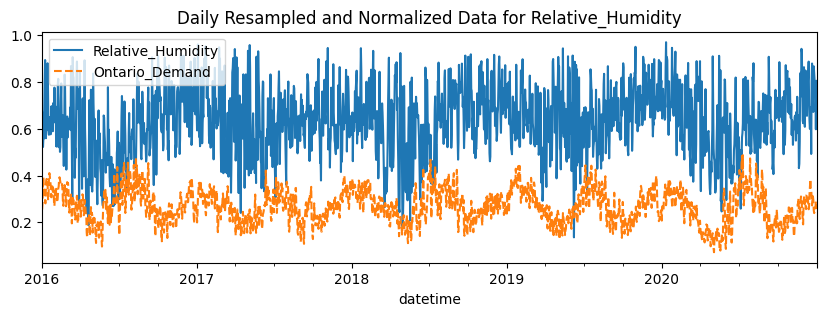

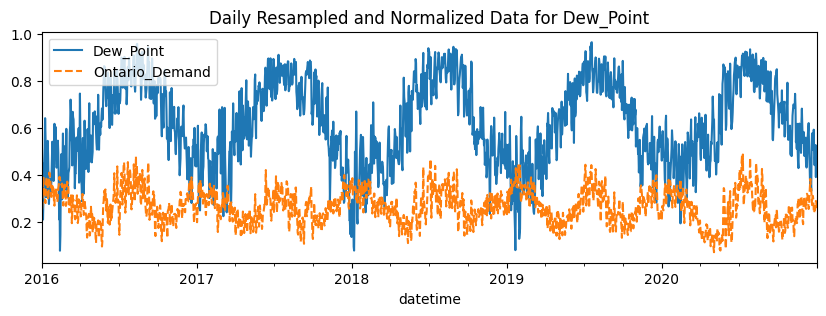

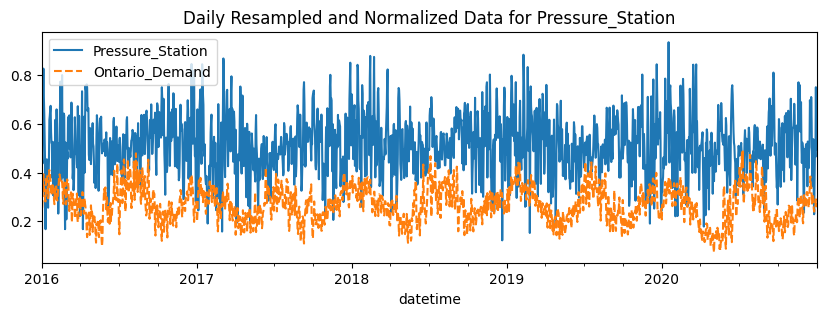

In [460]:
plot_timeseries(numeric_df, 'D')

#### **Observations**


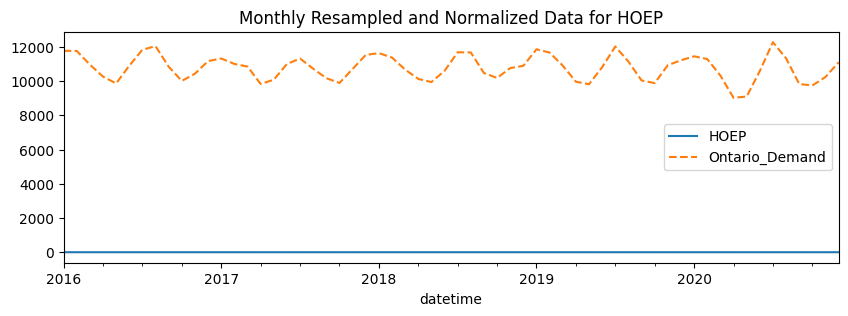

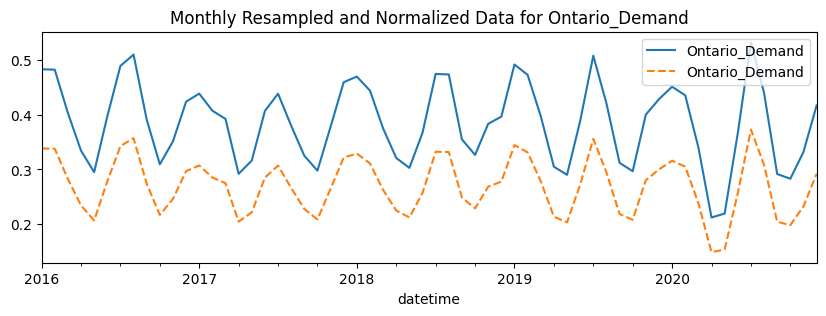

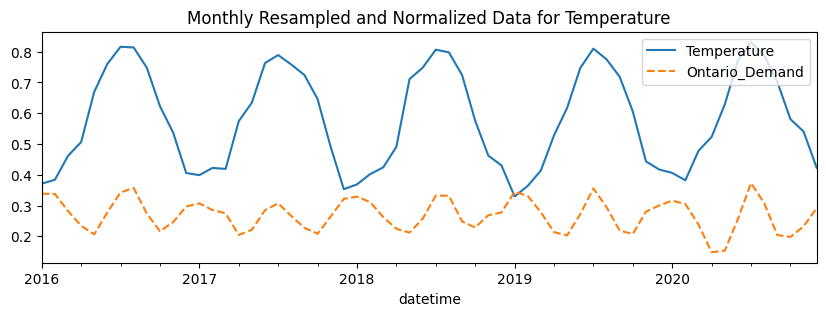

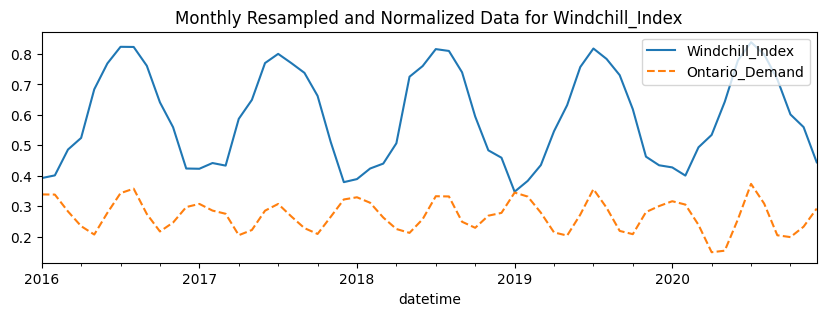

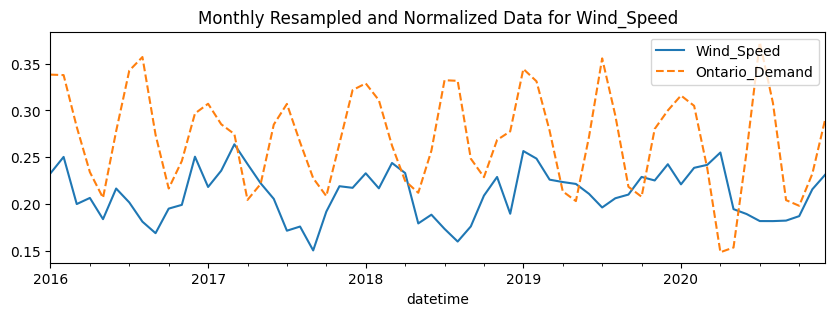

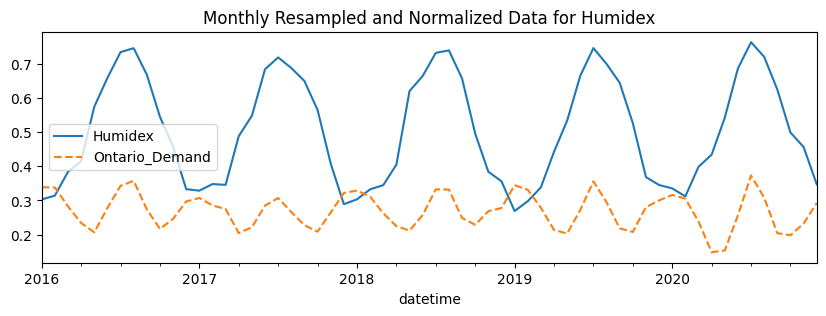

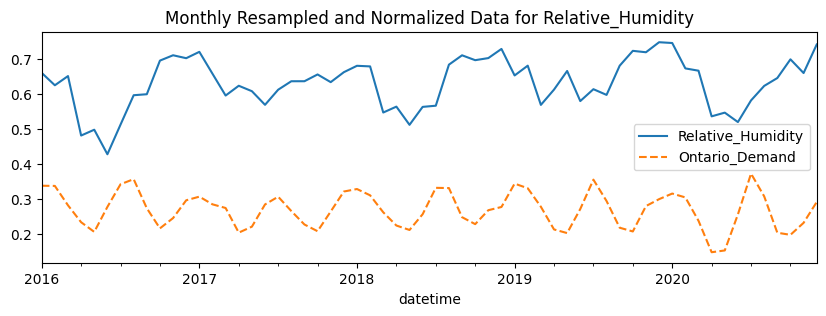

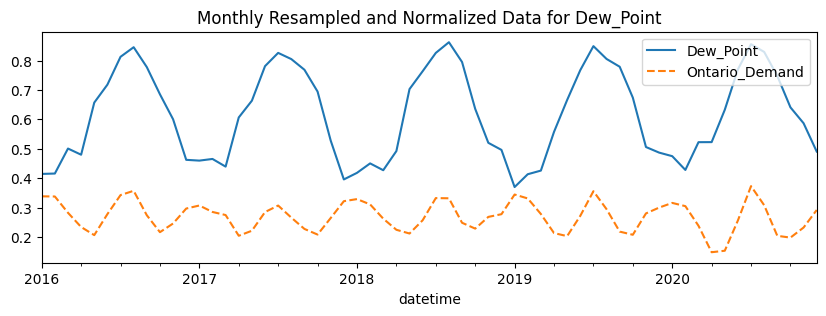

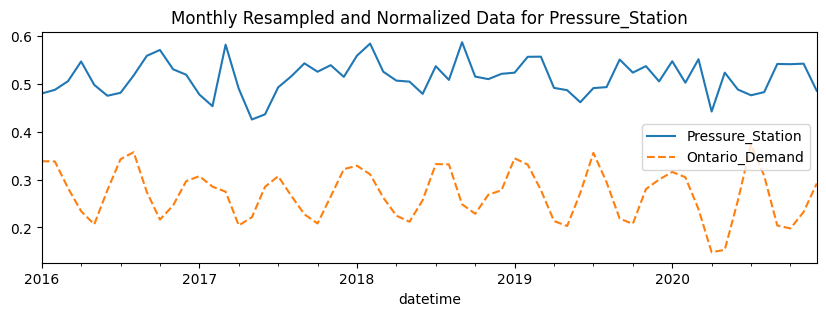

In [284]:
plot_timeseries(numeric_df, 'M')

In [248]:
d3 = df.copy()

In [249]:
# Extract the hour of the day from the 'datetime' column
hour = d3.Hour

# Create a new column with labels for 'morning', 'noon', and 'evening'
d3['time_of_day'] = pd.cut(hour, bins=[-1, 1, 3, 11, 16, 23], labels=['midnight', 'late night', 'morning', 'noon', 'evening'])

d3.head()

,Date,Weekday,Hour,HOEP,Ontario_Demand,Temperature,Windchill_Index,Wind_Speed,Humidex,Relative_Humidity,Dew_Point,Pressure_Station,time_of_day
datetime,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,Friday,0,0.49,14023,-0.3,-5.62,20,-3.18,70,-5.1,99.67,midnight
2016-01-01 01:00:00,2016-01-01,Friday,1,-1.09,13417,-0.3,-6.30,25,-3.48,68,-5.5,99.63,midnight
2016-01-01 02:00:00,2016-01-01,Friday,2,-2.41,12968,-0.4,-6.55,26,-3.43,73,-4.7,99.59,late night
2016-01-01 12:00:00,2016-01-01,Friday,12,0.00,14215,-2.1,-8.72,23,-4.86,76,-5.8,99.39,noon
2016-01-01 13:00:00,2016-01-01,Friday,13,0.00,14443,-2.4,-8.23,19,-5.09,84,-4.7,99.35,noon


In [250]:
# creating a weekend and weekday columns in numericals
d3['day_of_week'] = d3.index.dayofweek
d3['is_weekend'] = d3['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

**Time of Day:**
- 0-1 is Midnight
- 1-3 is Late Night
- 11-16 is noon
- 16-23 is evening

In [251]:
# creating a numerical month column
Month = d3.index.month
d3['Month'] = Month

In [467]:
# Multivariate Analysis Function

def demand_check(d3, column):
    max_val = d3.groupby(column)['Ontario_Demand'].max().sort_values()
    min_val = d3.groupby(column)['Ontario_Demand'].min().sort_values()
    mean_val = d3.groupby(column)['Ontario_Demand'].mean().sort_values().round()
    print(f'--Ontario Power Demand during {column}--')
    # Create a DataFrame to store the results
    demand_stats = pd.DataFrame({
        'Max_Demand': max_val,
        'Min_Demand': min_val,
        'Mean_Demand': mean_val
    })

    return demand_stats

    


In [468]:
demand_check(d3, 'time_of_day')

--Ontario Power Demand during time_of_day--


,Max_Demand,Min_Demand,Mean_Demand
time_of_day,,,
midnight,19991,10609,14237.0
late night,17641,10016,13231.0
morning,22055,9831,14522.0
noon,23735,10683,16077.0
evening,24281,11184,16785.0


In [469]:
demand_check(d3, 'Weekday')

--Ontario Power Demand during Weekday--


,Max_Demand,Min_Demand,Mean_Demand
Weekday,,,
Friday,23735,10554,15597.0
Monday,23909,9831,15577.0
Saturday,21828,10460,14714.0
Sunday,22777,10262,14544.0
Thursday,23179,10630,15764.0
Tuesday,24281,10175,15758.0
Wednesday,23724,10629,15777.0


In [470]:
demand_check(d3, 'is_weekend')

--Ontario Power Demand during is_weekend--


,Max_Demand,Min_Demand,Mean_Demand
is_weekend,,,
0,24281,9831,15695.0
1,22777,10262,14630.0


In [256]:
# Dropping Date and Hour columns
d3.drop(['Date', 'Hour'], axis=1, inplace=True)

In [257]:
# Decompose the time series into trend, seasonal, cyclical, and irregular components
decomp = seasonal_decompose(d3['Ontario_Demand'], model='multiplicative', period=365)
# Extract the components
trend = decomp.trend
seasonal = decomp.seasonal
cyclical = d3['Ontario_Demand'] - trend - seasonal
irregular = decomp.resid

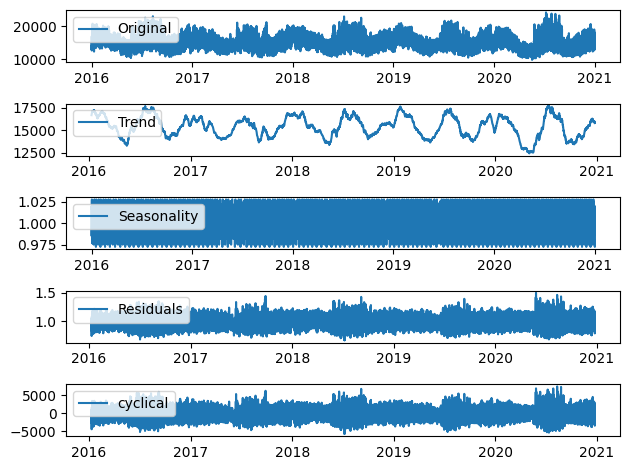

In [258]:
# Plot the components
plt.subplot(511)
plt.plot(d3['Ontario_Demand'], label='Original')
plt.legend(loc='upper left')

plt.subplot(512)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(513)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(514)
plt.plot(irregular, label='Residuals')
plt.legend(loc='upper left')

plt.subplot(515)
plt.plot(cyclical, label='cyclical')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


#In the plt.subplot() function, the numbers 411, 412, and 413 are used to specify 
#the position of each subplot in a 4x1 grid of subplots.
#Here's how the numbering works:
#The first digit represents the number of rows in the grid.
#The second digit represents the number of columns in the grid.
#The third digit represents the position of the subplot within the grid]

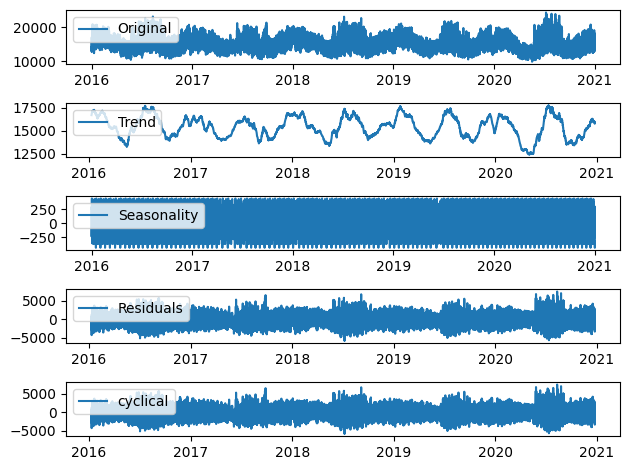

In [259]:
# Decompose the time series into trend, seasonal, cyclical, and irregular components
decomp = seasonal_decompose(d3['Ontario_Demand'], model='additive', period=365)
# Extract the components
trend = decomp.trend
seasonal = decomp.seasonal
cyclical = d3['Ontario_Demand'] - trend - seasonal
irregular = decomp.resid

# Plot the components
plt.subplot(511)
plt.plot(d3['Ontario_Demand'], label='Original')
plt.legend(loc='upper left')

plt.subplot(512)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(513)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(514)
plt.plot(irregular, label='Residuals')
plt.legend(loc='upper left')

plt.subplot(515)
plt.plot(cyclical, label='cyclical')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Stationary Test

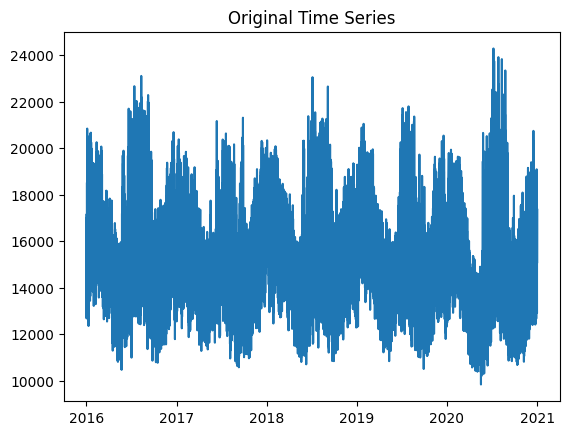

ADF Statistic:  -12.911359129993462
p-value:  4.0505288667732166e-24
Critical Values: 
1% :  -3.4305161726992512
5% :  -2.861613444482548
10% :  -2.5668090921452404


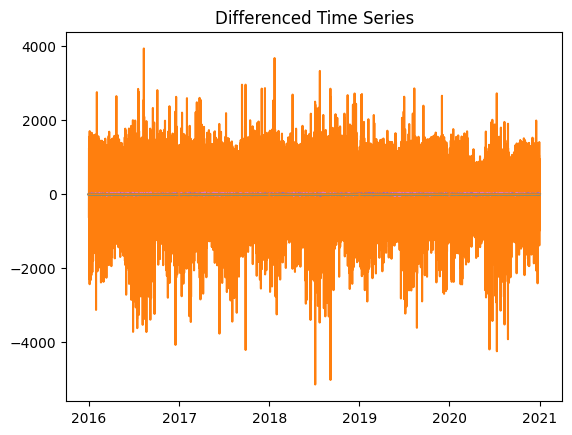

ADF Statistic:  -33.914997471428784
p-value:  0.0
Critical Values: 
1% :  -3.430516185368255
5% :  -2.861613450081797
10% :  -2.566809095125569


In [261]:
#using ADF
# Plot the time series
plt.plot(d3['Ontario_Demand'])
plt.title('Original Time Series')
plt.show()

# Test for stationarity
result = adfuller(d3['Ontario_Demand'])
print('ADF Statistic: ', result[0])
print('p-value: ', result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print(key, ": ", value)



# Apply the diff() function to the numeric DataFrame
numeric_d3 = d3.select_dtypes(include=[np.number])
    
# Difference the time series and plot
diff_data = numeric_d3.diff().dropna()
plt.plot(diff_data)
plt.title('Differenced Time Series')
plt.show()

# Test for stationarity of differenced time series
result = adfuller(diff_data['Ontario_Demand'])
print('ADF Statistic: ', result[0])
print('p-value: ', result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print(key, ": ", value)


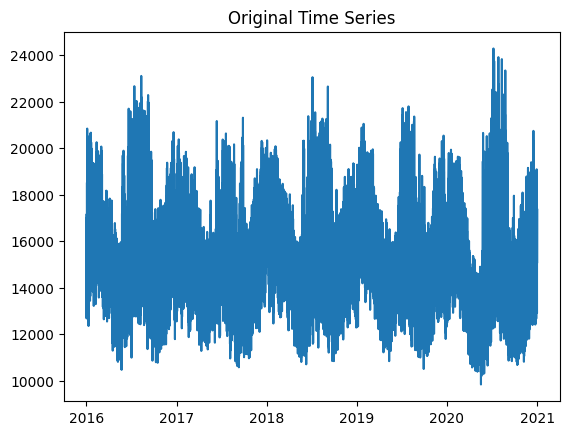

KPSS Statistic: 1.0409663794728705
p-value: 0.01
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


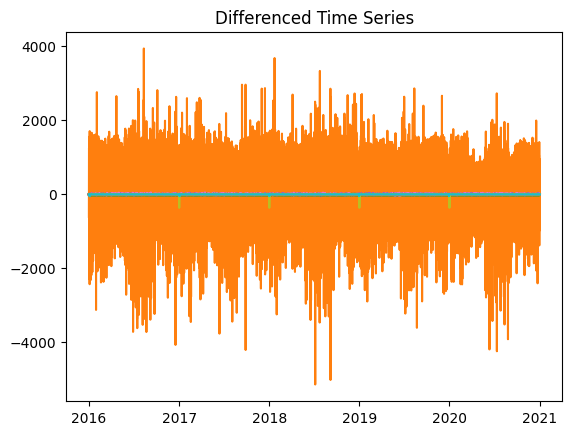

KPSS Statistic: 1.0409663794728705
p-value: 0.01
Critical Values:
10%: 0.347
5%: 0.463
2.5%: 0.574
1%: 0.739


In [324]:
# Using KPSS

# Plot the time series
plt.plot(d3['Ontario_Demand'])
plt.title('Original Time Series')
plt.show()

# Perform KPSS test
result = kpss(d3['Ontario_Demand'])

# Extract and print results
kpss_statistic = result[0]
p_value = result[1]
critical_values = result[3]

print('KPSS Statistic:', kpss_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

# Apply the diff() function to the numeric DataFrame
numeric_d3 = d3.select_dtypes(include=[np.number])
    
# Difference the time series and plot

diff_data = numeric_d3.diff().dropna()
plt.plot(diff_data)
plt.title('Differenced Time Series')
plt.show()

# Test for stationarity of differenced time series
# Perform KPSS test
result = kpss(d3['Ontario_Demand'])

# Extract and print results
kpss_statistic = result[0]
p_value = result[1]
critical_values = result[3]

print('KPSS Statistic:', kpss_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'{key}: {value}')

* Shows the Data is Nonstationary as the Null hypothesis is rejected in both

<Figure size 1200x400 with 0 Axes>

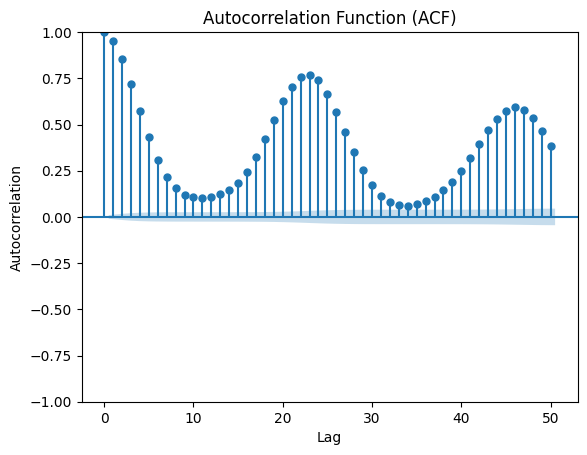

<Figure size 1200x400 with 0 Axes>

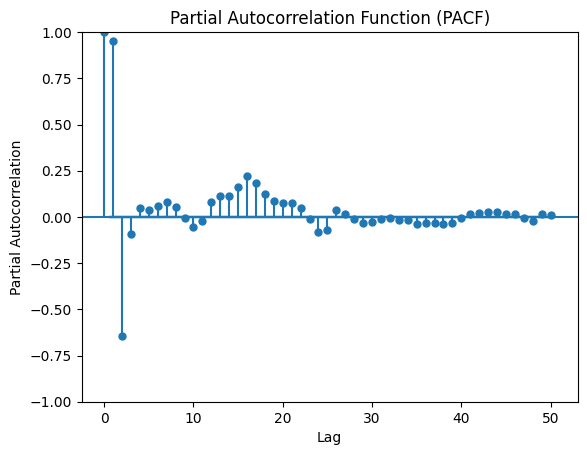

In [263]:
# Plot ACF
plt.figure(figsize=(12, 4))
plot_acf(d3['Ontario_Demand'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 4))
plot_pacf(d3['Ontario_Demand'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [394]:
def create_f(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['day_of_week'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    
    df['weekofyear'] = df['weekofyear'].astype('int64')
    return df

In [265]:
d3 = create_f(d3)

In [267]:
d3.columns

Index(['Weekday', 'HOEP', 'Ontario_Demand', 'Temperature', 'Windchill_Index',
       'Wind_Speed', 'Humidex', 'Relative_Humidity', 'Dew_Point',
       'Pressure_Station', 'time_of_day', 'day_of_week', 'is_weekend', 'Month',
       'hour', 'minute', 'day', 'month', 'year', 'dayofweek', 'dayofyear',
       'weekofyear'],
      dtype='object')

In [268]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39408 entries, 2016-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Weekday            39408 non-null  object  
 1   HOEP               39408 non-null  float64 
 2   Ontario_Demand     39408 non-null  int64   
 3   Temperature        39408 non-null  float64 
 4   Windchill_Index    39408 non-null  float64 
 5   Wind_Speed         39408 non-null  int64   
 6   Humidex            39408 non-null  float64 
 7   Relative_Humidity  39408 non-null  int64   
 8   Dew_Point          39408 non-null  float64 
 9   Pressure_Station   39408 non-null  float64 
 10  time_of_day        39408 non-null  category
 11  day_of_week        39408 non-null  int64   
 12  is_weekend         39408 non-null  int64   
 13  Month              39408 non-null  int64   
 14  hour               39408 non-null  int64   
 15  minute            

In [269]:
d3['weekofyear'] = d3['weekofyear'].astype('int64')

## Modeling 

In [285]:
# Selected Columns for Modeling

features = ['Temperature', 'HOEP', 'Wind_Speed', 'Relative_Humidity', 'Dew_Point',
           'Pressure_Station', 'Month', 'day_of_week', 'is_weekend',
            'hour', 'day', 'month', 'year', 'dayofweek',
           'dayofyear', 'weekofyear']
label = 'Ontario_Demand'


In [299]:
X = d3[features]
y = d3['Ontario_Demand']

In [310]:
# Define the models and parameter grids
models = [
    ('XGB', xgb.XGBRegressor(objective='reg:squarederror'), {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }),
    ('RandomForest', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }),
    ('SVR', SVR(), {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    })
]

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

best_models = {}

In [311]:
# Perform grid search for each model
for name, model, param_grid in models:
    print(f"Running grid search for {name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)
    
    # Store the best model and parameters
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Running grid search for XGB...
Best parameters for XGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Running grid search for RandomForest...
Best parameters for RandomForest: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Running grid search for SVR...
Best parameters for SVR: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}



<<Running Model: XGB>>
Training Data Lenght: 31525
Test Data Lenght: 7883
R-squared: 0.891
MAE: 634.0136741048776
MSE: 651913.0459740469
RMSE: 807.4113239074908
MAPE: 4.405092281213525%
Accuracy: 95.74964033826505%
Some predictions exceed 500 MW error.


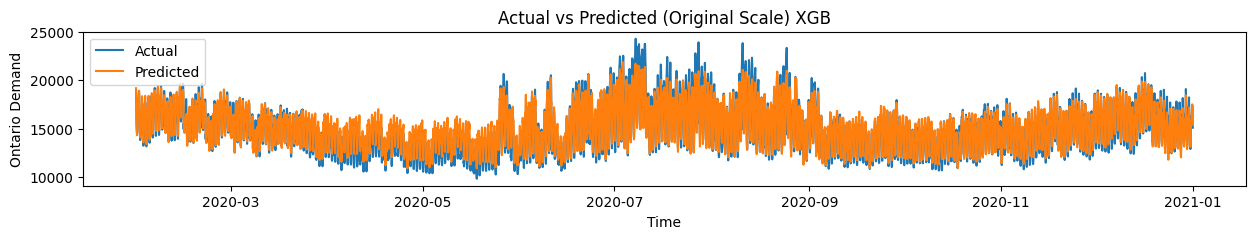

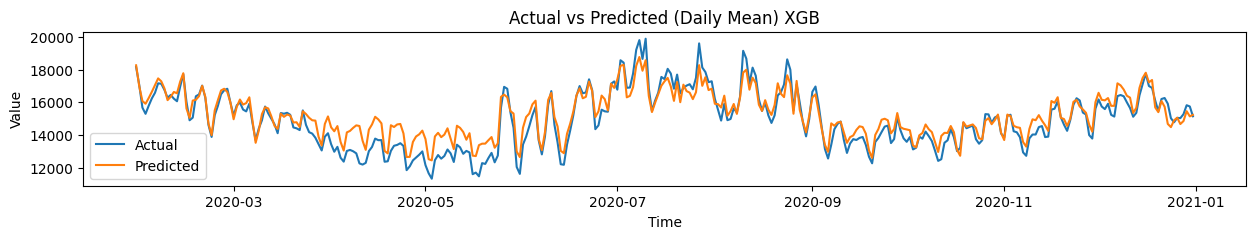


<<Running Model: RandomForest>>
Training Data Lenght: 31525
Test Data Lenght: 7883
R-squared: 0.770
MAE: 908.705234590799
MSE: 1372262.072753041
RMSE: 1171.4359021103294
MAPE: 6.354441564521111%
Accuracy: 93.90813758241873%
Some predictions exceed 500 MW error.


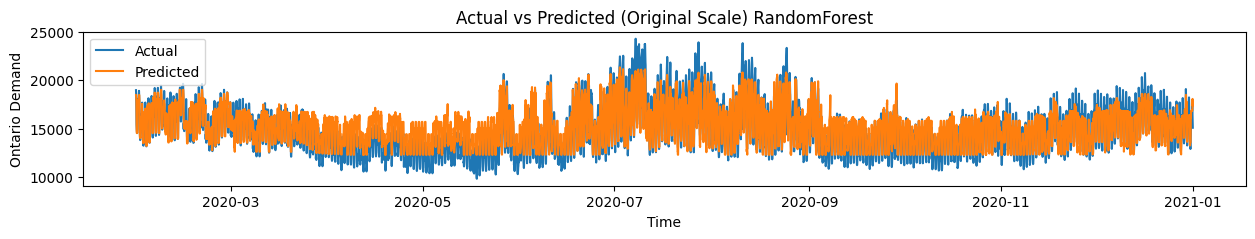

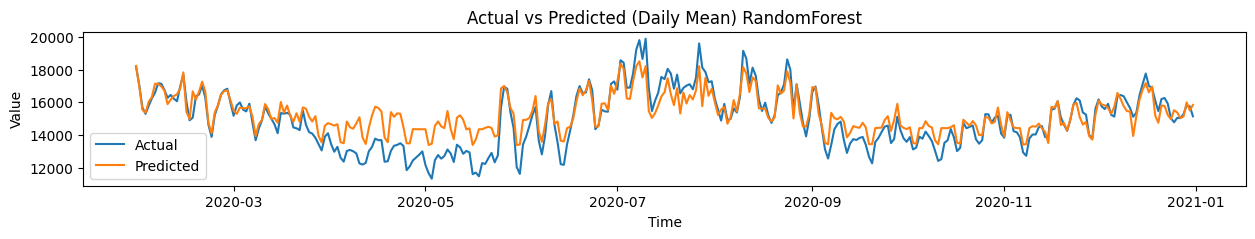


<<Running Model: SVR>>
Training Data Lenght: 31525
Test Data Lenght: 7883
R-squared: 0.518
MAE: 1337.9057473318242
MSE: 2877243.9374167784
RMSE: 1696.2440677617058
MAPE: 8.966922880303567%
Accuracy: 91.03082338454126%
Some predictions exceed 500 MW error.


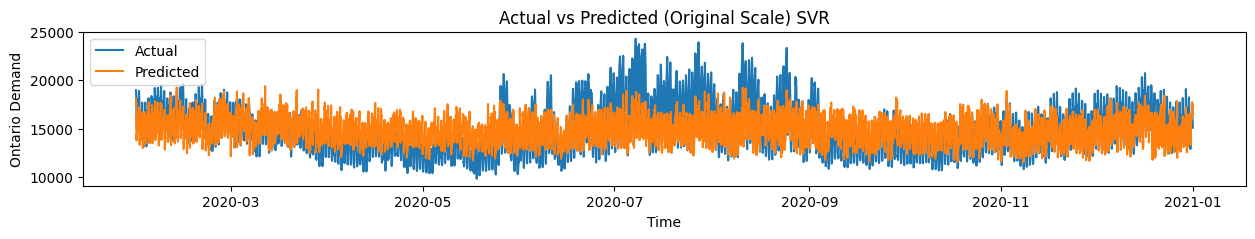

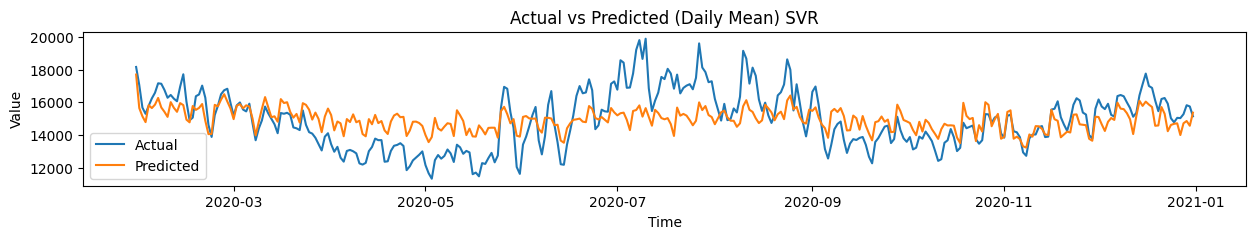

In [317]:
# Evaluate the best model for each regressor

results = []

for name, model in best_models.items():
    
    X_train, X_test, y_train,y_test = d3[features][0:31525], d3[features][31525:], d3[label][0:31525],  d3[label][31525:]
    
    print(f'\n<<Running Model: {name}>>')
    print(f'Training Data Lenght: {len(X_train)}')
    print(f'Test Data Lenght: {len(X_test)}')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    df_model = pd.DataFrame(data={'Actuals':y_test, 'Predictions':y_pred})
    
    
    
    # Assuming y_true and y_pred are your actual and predicted values
    y_true = d3[label][31525:]
    y_pred = df_model['Predictions']

    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Accuracy
    accuracy = 1 - mae / np.mean(y_true)
    
    
    print('R-squared: {:.3f}'.format(r2_score(df_model['Actuals'],df_model['Predictions'])))
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"Accuracy: {accuracy*100}%")

    # Check if Absolute Error is less than 500 MW
    absolute_errors = np.abs(y_true - y_pred)
    if np.all(absolute_errors < 500):
        print("All predictions are within 500 MW error.")
    else:
        print("Some predictions exceed 500 MW error.")
    
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'Accuracy': accuracy
    })
    
    plt.figure(figsize=(15,2))
    sns.lineplot(data = d3[label][31525:], label='Actual')
    sns.lineplot(data = df_model['Predictions'], label='Predicted')
    plt.title(f'Actual vs Predicted (Original Scale) {name}')
    plt.xlabel('Time')
    plt.ylabel('Ontario Demand')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(15,2))
    sns.lineplot(data = d3[label][31525:].resample('D').mean(), label='Actual')
    sns.lineplot(data = df_model['Predictions'].resample('D').mean(), label='Predicted')
    plt.title(f'Actual vs Predicted (Daily Mean) {name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
results_df = pd.DataFrame(results)

In [471]:
best_models

{'XGB': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'RandomForest': RandomForestRegressor(max_depth=7, min_samples_leaf=2, n_estimators=50),
 'SVR': SVR(C=0.1, kernel='linear')}

In [318]:
results_df

,Model,MAE,MSE,RMSE,MAPE,Accuracy
0,XGB,634.013674,6.519130e+05,807.411324,4.405092,0.957496
1,RandomForest,908.705235,1.372262e+06,1171.435902,6.354442,0.939081
2,SVR,1337.905747,2.877244e+06,1696.244068,8.966923,0.910308


# Prediction

In [403]:
monthly_data = d3[d3['month'] == 7]

# Initialize dictionaries to store min and max values
min_values = {}
max_values = {}

# Iterate through the features to get min and max values
for feature in features:
    min_values[feature] = monthly_data[feature].min()
    max_values[feature] = monthly_data[feature].max()

# Specify the features to get min and max values for
features = ['Temperature', 'HOEP', 'Wind_Speed', 'Relative_Humidity', 'Dew_Point',
           'Pressure_Station', 'Month', 'day_of_week', 'is_weekend',
            'hour', 'day', 'month', 'year', 'dayofweek',
           'dayofyear', 'weekofyear']

# Get user input for start and end dates
#startd = input("Enter the Start Date in format Year-Month-Date: ")
#endd = input("Enter the End Date in format Year-Month-Date: ")

# Generate random samples for the specified date range using the min and max values
data = {
    'Date': pd.date_range(start='2022-07-08', end='2022-07-09', freq='H'),
}

for feature in features:
    if feature in ['day_of_week', 'is_weekend',
                   'hour', 'day', 'month', 'year', 'dayofweek',
                   'dayofyear', 'weekofyear']:
        continue    
    else:
        data[feature] = np.random.uniform(low=min_values[feature], high=max_values[feature], size=len(data['Date']))

# Create the DataFrame with the generated data
forecast_df = pd.DataFrame(data)
forecast_df.set_index('Date', inplace=True)

forecast_df = create_f(forecast_df)


# Display the generated DataFrame
forecast_df.head()

,Temperature,HOEP,Wind_Speed,Relative_Humidity,Dew_Point,Pressure_Station,Month,hour,minute,day,month,year,dayofweek,day_of_week,dayofyear,weekofyear
Date,,,,,,,,,,,,,,,,
2022-07-08 00:00:00,22.401485,19.880841,6.968426,24.023865,18.487223,98.646447,7.0,0,0,8,7,2022,4,4,189,27
2022-07-08 01:00:00,12.863185,8.964317,32.763749,54.666157,6.774637,100.530124,7.0,1,0,8,7,2022,4,4,189,27
2022-07-08 02:00:00,27.220864,16.723661,44.488284,60.570470,17.511707,100.466932,7.0,2,0,8,7,2022,4,4,189,27
2022-07-08 03:00:00,31.595547,3.914337,49.109953,78.120637,19.679696,98.457850,7.0,3,0,8,7,2022,4,4,189,27
2022-07-08 04:00:00,22.405966,35.626689,20.427226,33.704517,19.782843,99.535356,7.0,4,0,8,7,2022,4,4,189,27


In [396]:
len(forecast_df.columns)

16

In [422]:
xgb_model = best_models['XGB']
demand_pred = xgb_model.predict(forecast_df)

In [413]:
mask = (d3['month'] == 7) & (d3['year'] == 2020) & (d3['day'] == 8)

In [414]:
actual_july2020 = d3[mask]['Ontario_Demand']

In [424]:
pd.DataFrame(actual_july2020)

,Ontario_Demand
datetime,
2020-07-08 00:00:00,19367
2020-07-08 01:00:00,17713
2020-07-08 02:00:00,16709
2020-07-08 03:00:00,16070
2020-07-08 04:00:00,15623
2020-07-08 05:00:00,15445
2020-07-08 06:00:00,15523
2020-07-08 07:00:00,16164
2020-07-08 08:00:00,17710


In [432]:
july_21=pd.DataFrame(July_demand_2021)

In [405]:
July_demand_2022 = demand_pred

In [401]:
July_demand_2023 = demand_pred

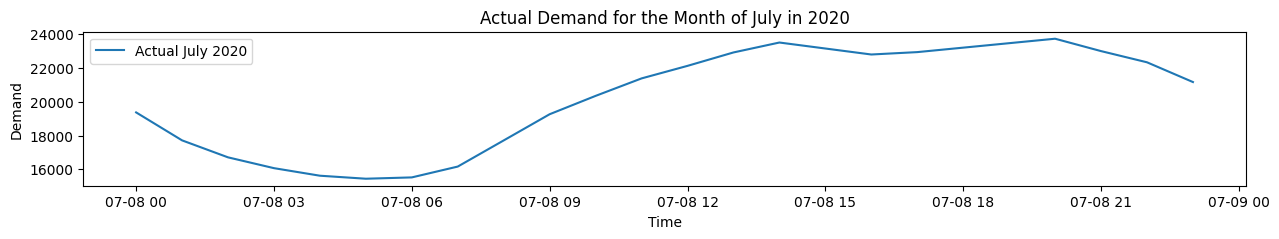

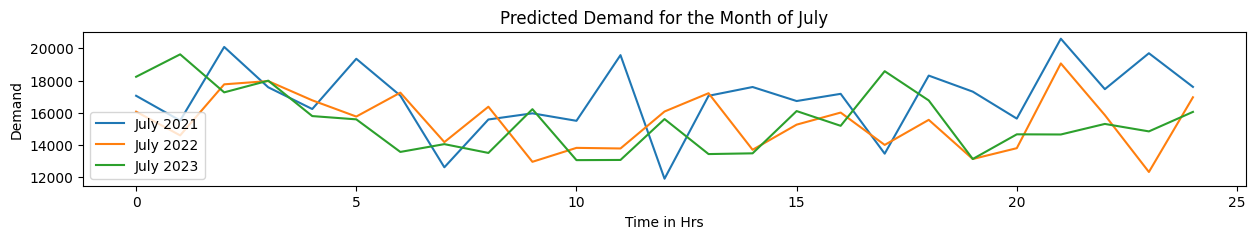

In [441]:
plt.figure(figsize=(15,2))
sns.lineplot(data = actual_july2020, label='Actual July 2020')
plt.title('Actual Demand for the Month of July in 2020')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

plt.figure(figsize=(15,2))
sns.lineplot(data = July_demand_2021, label='July 2021')
sns.lineplot(data = July_demand_2022, label='July 2022')
sns.lineplot(data = July_demand_2023, label='July 2023')

plt.title('Predicted Demand for the Month of July')
plt.xlabel('Time in Hrs')
plt.ylabel('Demand')
plt.legend()
plt.show()

## Saving the Model

In [442]:
import pickle
file_name = "model_xgb.pkl"
#model.save_model('model1.json')
pickle.dump(model2, open(file_name, "wb"))